# Predicting whether a DNA sequence region is binding site to a specifictranscription factor.



In this Kaggle Competition we were working on binary classification task of predicting whether a DNA sequence region is binding site to a specifictranscription factor.




## [Optuna](https://optuna.org/) 
- A hyperparameter optimization framework

## [cvxopt](https://cvxopt.org/) 
- A convex optimization package

In [1]:
!pip install cvxopt -q
!pip install optuna -q

In [2]:
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score


import os
import optuna
import random
import cvxopt
import cvxopt.solvers
import sklearn

cvxopt.solvers.options['show_progress'] = False

### Read the data

In [3]:
np.random.seed(42)
random.seed(42)

In [4]:
X_test_ = pd.read_csv('data/Xte.csv',sep=',',index_col=0)
X_train_ = pd.read_csv('data/Xtr.csv',sep=',',index_col=0)

X_test_mat100 = pd.read_csv('data/Xte_mat100.csv',sep=' ',header=None).values
X_train_mat100 = pd.read_csv('data/Xtr_mat100.csv',sep=' ',header=None).values

y = pd.read_csv('data/Ytr.csv',sep=',',index_col=0)

### Fuction will help us get the label 

- Label will be  0 or 1 if we use type=0
- label will be -1 or 1 if we use type=-1

In [5]:
def get_label(type=0):
    y = pd.read_csv('data/Ytr.csv',sep=',',index_col=0)
    if type == 0:
        y = y.Bound.values
        return y
    else:
        y['Bound'] = y.Bound.apply(lambda x: -1 if x == 0 else 1)
        y = y.Bound.values
        return y
    
get_label(0)

array([1, 0, 1, ..., 1, 1, 1])

### This function will return train-val split data using sklearns built in train_test_split

In [6]:
def get_train_test(X,y,p):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=p, random_state=42)
    print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

# 1.EDA

In [7]:
# THE DATA 
X_train_.head()

,seq
Id,
0,GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGA...
1,CGGCCTGGGGGCCACATGTGAGTGCTTACCTGTGTGGGGATGAGGG...
2,GACAACGCCGCTGTCAGCCGCCTTCGACTCACCTGGGAGGTGATGA...
3,GCCTCCCTTGGCACCACGGGAGACCAGTTTTGGAGGGGCGGGGCTG...
4,GCACTACTACACCCATTGCTGTAATAGTAAGTGCCGGTGCCTTCAC...


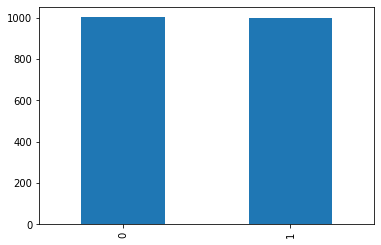

In [8]:
# THE DATA IS PROPORTIONAL DATA 
y['Bound'].value_counts().plot.bar()

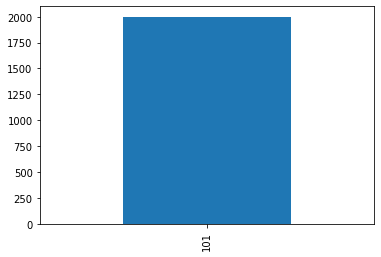

In [9]:
# ADDITIONALLY ALL DATA CONTAINS 101 LENGTH SEQUENCES SO THERE WILL BE NO NEED OF PADDING 
X_train_['Count'] = X_train_.seq.apply(lambda x:len(x))
X_train_['Count'].value_counts().plot.bar()

#  Data Related Experiments
---------------------------------------------------------

### One Hot Encoding
--------------------------------------

In [10]:
print('sequence = ', X_train_.seq.values[0])
print('scaled version of One Hot Representation =',X_train_mat100[0])

sequence =  GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGAACCACCCAGGCATTGTGGGGCTGCCCTGCCACCTGCTGGCCGCTCCTGGTGGCAG
scaled version of One Hot Representation = [0.01086957 0.01086957 0.01086957 0.0326087  0.01086957 0.0326087
 0.01086957 0.         0.         0.01086957 0.0326087  0.
 0.         0.01086957 0.02173913 0.01086957 0.01086957 0.01086957
 0.         0.0326087  0.02173913 0.         0.         0.01086957
 0.01086957 0.01086957 0.         0.02173913 0.         0.01086957
 0.01086957 0.04347826 0.         0.01086957 0.01086957 0.01086957
 0.         0.01086957 0.04347826 0.01086957 0.02173913 0.02173913
 0.         0.         0.01086957 0.02173913 0.02173913 0.
 0.         0.         0.         0.01086957 0.         0.0326087
 0.01086957 0.         0.01086957 0.         0.01086957 0.02173913
 0.         0.01086957 0.01086957 0.02173913 0.01086957 0.
 0.01086957 0.01086957 0.01086957 0.         0.         0.
 0.         0.         0.01086957 0.01086957 0.         0.02173913
 0.010

### Ordinal encoding DNA
-------------------------------------------------------

we assign 

    A - 0.25
    C - 0.50
    G - 0.71
    T - 1.0
    
    
and convert data to matrix


In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['A','C','G','T']))

def ordinal_encoder(sequence):
    integer_encoded = label_encoder.transform(np.array(list(sequence)))
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25
    float_encoded[float_encoded == 1] = 0.50
    float_encoded[float_encoded == 2] = 0.75
    float_encoded[float_encoded == 3] = 1.00 
    return float_encoded

def get_ordinal_data(x_train):
    X_list = []
    for i in x_train:
        X_list.append(ordinal_encoder(i))
    return np.array(X_list)


In [12]:
print('sequence = ', X_train_.seq.values[0])
print('scaled version of One Hot Representation =',get_ordinal_data(X_train_.seq.values)[0])

sequence =  GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGAACCACCCAGGCATTGTGGGGCTGCCCTGCCACCTGCTGGCCGCTCCTGGTGGCAG
scaled version of One Hot Representation = [0.75 0.25 0.75 0.75 0.75 0.75 0.5  1.   0.75 0.75 0.75 0.75 0.25 0.75
 0.75 0.75 0.75 0.75 0.5  1.   0.75 0.75 0.5  0.5  0.5  0.25 0.75 0.25
 0.75 0.75 0.5  0.25 0.5  0.5  0.25 0.75 0.25 0.5  1.   0.5  1.   0.75
 0.5  0.25 0.75 0.25 0.25 0.5  0.5  0.25 0.5  0.5  0.5  0.25 0.75 0.75
 0.5  0.25 1.   1.   0.75 1.   0.75 0.75 0.75 0.75 0.5  1.   0.75 0.5
 0.5  0.5  1.   0.75 0.5  0.5  0.25 0.5  0.5  1.   0.75 0.5  1.   0.75
 0.75 0.5  0.5  0.75 0.5  1.   0.5  0.5  1.   0.75 0.75 1.   0.75 0.75
 0.5  0.25 0.75]


## K-mer counting/Spectral Embedding
--------------------------------------------------------


K-mer of size 3 

    'ACAAT' = ['aca', 'caa', 'aat']

In [13]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [14]:
def base2int(c):
    return {'a':0,'c':1,'g':2,'t':3}.get(c,0)

def index(kmer):
    base_idx = np.array([base2int(base) for base in kmer])
    multiplier = 4** np.arange(len(kmer))
    kmer_idx = multiplier.dot(base_idx)
    return kmer_idx

def spectral_embedding(sequence,kmer_size=3):
    kmers = getKmers(sequence,kmer_size)
    kmer_idxs = [index(kmer) for kmer in kmers]
    one_hot_vector = np.zeros(4**kmer_size)
    
    for kmer_idx in kmer_idxs:
        one_hot_vector[kmer_idx] += 1
    return one_hot_vector

def get_data(kmer_size):
    data = pd.DataFrame(pd.concat([X_train_.seq,X_test_.seq],axis=0))
    train_text = data.seq.values
    kmer_data = []
    for i in train_text:
        kmer_data.append(spectral_embedding(i,kmer_size=kmer_size))

    return np.array(kmer_data)

## Count Vectorizer / TfidfTransformer
-------------------------------------------------------


#### Count Vectorizer 
    
   - ngram_range = 2,analyzer='char'
    
    'ACAAATTTGGGGAAA' - [4, 1, 1, 1, 1, 3, 1, 2]
    
 
#### TfidfVectorizer 

   - ngram_range = 2,analyzer='char'

    'ACAAATTTGGGGAAA' - [0.68599434, 0.17149859, 0.17149859, 0.17149859, 0.17149859,
        0.51449576, 0.17149859, 0.34299717]

In [15]:
def get_count_grams(data,n=6):
    cv = CountVectorizer(analyzer='char',ngram_range=(n,n))
    X = cv.fit_transform(data).toarray()
    return X

def get_tf_idf_grams(data,n=6):
    cv = TfidfVectorizer(analyzer='char',ngram_range=(n,n))
    X = cv.fit_transform(data).toarray()
    return X

# Algorithm Related Experiments
-----------------------------------------------

We started this experiment with a simple logistic regression with a batch gradient descent. 
This algorithm was train and validated with the  data processings we did above. 

## 1. Logistic Regression 
---------------------------------

In [45]:
class logisticregression():
    def __init__(self,train_data,train_labels,lamda=0.2,lr=0.01,decay=10,batch_size=64,epoch=10,print_every = 10):
        dummy_once = np.ones((len(train_data),1))
        self.train_data = np.hstack((dummy_once,train_data))
        self.train_labels = train_labels
        
        self.params = np.zeros((len(self.train_data[0]),1))
        
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.print_every = print_every
        self._lambda = lamda
        self.decay = decay
        
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def cost(self,y,y_pred):
        return -np.mean(y*np.log(y_pred)+(1-y)*np.log(1-y_pred))
    
    def gradient(self,y,y_pred,x):
        return np.dot(x.T,(y_pred-y))+(2*(self._lambda/len(self.train_labels ))*self.params)
    
    def train(self):
        for i in range(self.epoch):
            for j in range(len(self.train_labels)//self.batch_size):
                idx = list(np.random.choice(np.arange(len(self.train_labels)),self.batch_size,replace=False))
                data = self.train_data[idx]
                label = self.train_labels[idx]

                y_pred = self.sigmoid(np.dot(data,self.params))
                loss = self.cost(label,y_pred)

                gra = self.gradient(label,y_pred,data)
                self.params -= self.lr*gra

                self.lr *= (1. / (1. + self.decay * i))
            
            if self.print_every:
                if i%self.print_every == 0 or i == self.epoch-1:
                    print('Epoch : {}  Loss: {}'.format(i,loss))
    def predict(self,test_data):
        result = self.sigmoid(np.dot(test_data,self.params[1:])+self.params[0])
        result[result > 0.5 ] = 1
        result[result <= 0.5 ] = 0
        return result
    
    def evaluate(self,test_data,labels):
        accuracy = accuracy_score(self.predict(test_data),labels)
        return accuracy

In [46]:
def cross_validate(x_data,y_data,lr,lamda=0.2,epoch=10,k=4,batch_size=64,decay=10):
    if len(x_data)%k != 0:
        print('cant vsplit',len(x_data),' by ',k)
        return
    
    x_data_splitted = np.vsplit(x_data,k)
    y_data_splitted = np.vsplit(y_data,k)
    
    aggrigate_result = []
    for i in range(len(x_data_splitted)):
        train = []
        test = []
        items = [j for j in range(len(x_data_splitted)) if j !=i ]
        x_test = x_data_splitted[i]
        y_test = y_data_splitted[i]
        for item in items:
            if len(train) == 0:
                x_train = x_data_splitted[item]
                y_train = y_data_splitted[item]
            else:
                x_train = np.concatenate((x_train,x_data_splitted[item]), axis=0)
                y_train = np.concatenate((y_train,y_data_splitted[item]), axis=0)
        
        logistic = logisticregression(x_train,y_train,batch_size=batch_size,lamda=lamda,lr=lr,decay=decay,epoch=epoch,print_every=None)
        logistic.train()
        
        result = logistic.evaluate(x_test,y_test)
        aggrigate_result.append(result)
        
        value = sum(aggrigate_result)/len(aggrigate_result)
    return value

In [47]:
one_hot_result = cross_validate(X_train_mat100,get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
ordinal_result = cross_validate(get_ordinal_data(X_train_.seq.values),get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
kmer_result = cross_validate(get_data(6)[:2000,:],get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
count_result = cross_validate(get_count_grams(X_train_.seq.values,6),get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)
tfidf_result = cross_validate(get_tf_idf_grams(X_train_.seq.values,6),get_label(type=0).reshape(-1,1),k=5,lr=0.01,batch_size=32,lamda=5,epoch=100)

### Test which data is better representation
----------------------------------------------


 The First Result Shows The Quality of the data on a simple logistic regression without any hyper-parameters search. Meaning that this is not the best value this method can achive but it can show us the quality of the data preprocessing
 
- The parameters of logistic regression was not optimized for each data so this result might not show the real value.
 
- Count Vectorizer is the best representation so far 

In [49]:
final_value = {'One Hot':one_hot_result,'Ordinal':ordinal_result,'K-mer':kmer_result,'Count-Vectorizer':count_result,'Tf-idf':tfidf_result}
final_value

for k,v in final_value.items():
    print('{} === {}'.format(k,v))

One Hot === 0.483
Ordinal === 0.49499999999999994
K-mer === 0.607
Count-Vectorizer === 0.624
Tf-idf === 0.5189999999999999


## Algorithm Related Experiments +  Kernel Related Experiments
------------------------------------------------------------------------

We already experimented with Logistic regression now we will add 

- Ridge Regression
- SVM
- Kernelized Method of the Variants

In the folowing lines of code  define a set of kernels that we will applied with ridge regression and SVM. 

In [16]:
def sigma_from_median(X):
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

def linear_kernel(x1, x2):
    return np.dot(x1, x2.T)

def polynomial_kernel(X1, X2, power=2):
    return np.power((1 + linear_kernel(X1, X2)),power)

def rbf_kernel(X1, X2, sigma=10):
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K


#### This is Base class for all Kernelized method we saw in class 
     
All kernelized methods are derived from this class 

In [17]:
class KernelMethodBase(object):
    kernels_ = {
        'linear': linear_kernel,
        'polynomial': polynomial_kernel,
        'rbf': rbf_kernel,
        'gaussian':gaussian_kernel
    }
    def __init__(self, kernel='linear', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf' or self.kernel_name == 'gaussian':
            params['sigma'] = kwargs.get('sigma', None)
        if self.kernel_name == 'polynomial':
            params['power'] = kwargs.get('power', None)
        return params

    def fit(self, X, y, **kwargs):
        return self
        
    def decision_function(self, X):
        pass

    def predict(self, X):
        pass

### Kernel Ridge Regression
--------------------------------------------

- Here is  implementation of ridge regression with kernel.
- We train this model with alll the kernels above.
- It gives the best performance in the leaderboard with linear kernel.

In [18]:
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, lambd=0.1, **kwargs):
        self.lambd = lambd
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelRidgeRegression, self).__init__(**kwargs)

    def fit(self, X, y, sample_weights=None):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        if sample_weights is not None:
            w_sqrt = np.sqrt(sample_weights)
            self.X_train = self.X_train * w_sqrt[:, None]
            self.y_train = self.y_train * w_sqrt
        
        A = self.kernel_function_(X,X,**self.kernel_parameters)
        A[np.diag_indices_from(A)] = np.add(A[np.diag_indices_from(A)],n*self.lambd)
        # self.alpha = (K + n lambda I)^-1 y
        self.alpha = np.linalg.solve(A , self.y_train)

        return self
    
    def decision_function(self, X):
        K_x = self.kernel_function_(X,self.X_train, **self.kernel_parameters)
        return K_x.dot(self.alpha)
    
    def predict(self, X):
        return self.decision_function(X)

### SVM with all the kernels defined above.
-----------------------------------------------------

- After training, we realized that the linear kernel with the k-mer data was giving the best result(65% on cross validation).

In [19]:
class KernelSVM(KernelMethodBase):
    def __init__(self, C=0.1, **kwargs):
        self.C = C
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelSVM, self).__init__(**kwargs)
        
    def cvxopt_qp(self,P, q, G, h, A, b):
        P = .5 * (P + P.T)
        cvx_matrices = [
            cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
        ]
        #cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(*cvx_matrices, options={'show_progress': False})
        return np.array(solution['x']).flatten()
    
    def svm_dual_soft_to_qp_kernel(self,K, y, C=1):
        n = K.shape[0]
        assert (len(y) == n)

        # Dual formulation, soft margin
        # P = np.diag(y) @ K @ np.diag(y)
        P = np.diag(y).dot(K).dot(np.diag(y))
        # As a regularization, we add epsilon * identity to P
        eps = 1e-12
        P += eps * np.eye(n)
        q = - np.ones(n)
        G = np.vstack([-np.eye(n), np.eye(n)])
        h = np.hstack([np.zeros(n), C * np.ones(n)])
        A = y[np.newaxis, :]
        b = np.array([0.])
        return P, q, G, h, A.astype(float), b


    def fit(self, X, y, tol=1e-8):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        # Kernel matrix
        K = self.kernel_function_(
            self.X_train, self.X_train, **self.kernel_parameters)
        
        # Solve dual problem
        self.alpha = self.cvxopt_qp(*self.svm_dual_soft_to_qp_kernel(K, y, C=self.C))
        
        # Compute support vectors and bias b
        sv = np.logical_and((self.alpha > tol), (self.C - self.alpha > tol))
        self.bias = y[sv] - K[sv].dot(self.alpha * y)
        self.bias = self.bias.mean()

        self.support_vector_indices = np.nonzero(sv)[0]

        return self
        
    def decision_function(self, X):
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)
        return K_x.dot(self.alpha * self.y_train) + self.bias

    def predict(self, X):
        return np.sign(self.decision_function(X))

### We cross validated all of our submissions to avoud overfitting


In [20]:
def cross_validate(x_data,y_data,model_name,lr=None,kernel=None,lambd=0.2,C=3,sigma=0.5,k=5,power=2):
    if len(x_data)%k != 0:
        print('cant vsplit',len(x_data),' by ',k)
        return

    x_data_splitted = np.vsplit(x_data,k)
    y_data_splitted = np.vsplit(y_data.reshape(-1,1),k)

    aggrigate_result = []
    for i in range(len(x_data_splitted)):
        train = []
        test = []
        items = [j for j in range(len(x_data_splitted)) if j !=i ]
        x_test = x_data_splitted[i]
        y_test = y_data_splitted[i]
        for item in items:
            if len(train) == 0:
                x_train = x_data_splitted[item]
                y_train = y_data_splitted[item]
            else:
                x_train = np.concatenate((x_train,x_data_splitted[item]), axis=0)
                y_train = np.concatenate((y_train,y_data_splitted[item]), axis=0)

        if model_name == 'KernelRidgeRegression':
            model = KernelRidgeRegression(
                    kernel=kernel,
                    lambd=lambd,
                    sigma=sigma,
                    power=power
                ).fit(x_train, y_train)
            result =sum(np.sign(model.predict(x_test))==y_test)/len(y_test)#roc_auc_score(np.sign(model.predict(x_test)),y_test) #

        elif model_name == 'KernelSVM':

            model = KernelSVM(C=C,
                              kernel=kernel,
                              lambd=lambd,
                              sigma=sigma,
                              power=power)
            model.fit(x_train, y_train.flatten())
            y_pred = model.predict(x_test)

            result = sum((y_pred.flatten()==y_test.flatten()))/len(y_test)

        else:
            print('wrong model_name')
            return 0

        aggrigate_result.append(result)

        value = sum(aggrigate_result)/len(aggrigate_result)
    return value

## [Optuna](https://optuna.org/) 

- A hyperparameter optimization framework
- we tried to get the best hyperparameters for the models we worked on using this.

In [24]:
def objective(trial):
#     lambd = trial.suggest_float('lambd', 1e-5, 100.0)
    sigma = trial.suggest_float('sigma', 1e-5, 150)
    k =  trial.suggest_categorical('k', [4,5,8])
    C =  trial.suggest_float('C', 0.1,50)
#     power =  trial.suggest_int('power', 2,5)
    kmer_size =  trial.suggest_int('kmer_size', 3,8)
#     kernel =  trial.suggest_categorical('kernel', ['linear','rbf','gaussian_kernel','polynomial'])
#     model_name
    
    return cross_validate(get_data(kmer_size)[:2000,:],get_label(type=-1),model_name='KernelSVM',C=C,kernel='rbf',lambd=0,k=k,sigma=sigma,power=1)

# cross_validate(X_train_mat100, y,lamda=0.01,k=4)
import optuna

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
df = study.optimize(func=objective, n_trials=100,show_progress_bar=True)

[I 2020-06-01 10:32:21,828] Finished trial#0 with value: 0.562 with parameters: {'sigma': 128.99795620168032, 'k': 5, 'C': 22.54113808303137, 'kmer_size': 3}. Best is trial#0 with value: 0.562.
[I 2020-06-01 10:32:23,962] Finished trial#1 with value: 0.5725 with parameters: {'sigma': 24.400117286390017, 'k': 8, 'C': 35.79361689279468, 'kmer_size': 4}. Best is trial#1 with value: 0.5725.
[I 2020-06-01 10:32:26,520] Finished trial#2 with value: 0.583 with parameters: {'sigma': 66.01415659934182, 'k': 4, 'C': 29.44839669923022, 'kmer_size': 4}. Best is trial#2 with value: 0.583.
[I 2020-06-01 10:32:28,980] Finished trial#3 with value: 0.5835 with parameters: {'sigma': 83.66670812198443, 'k': 4, 'C': 49.82572811712092, 'kmer_size': 4}. Best is trial#3 with value: 0.5835.
[I 2020-06-01 10:32:37,115] Finished trial#4 with value: 0.6425 with parameters: {'sigma': 87.437965421459, 'k': 5, 'C': 46.820413160314324, 'kmer_size': 8}. Best is trial#4 with value: 0.6425.
[I 2020-06-01 10:32:39,520] 

[I 2020-06-01 10:35:48,735] Finished trial#40 with value: 0.6475 with parameters: {'sigma': 65.85012221827802, 'k': 4, 'C': 11.211238628207138, 'kmer_size': 8}. Best is trial#37 with value: 0.656.
[I 2020-06-01 10:35:53,118] Finished trial#41 with value: 0.642 with parameters: {'sigma': 12.630859648668418, 'k': 4, 'C': 17.136727203415578, 'kmer_size': 7}. Best is trial#37 with value: 0.656.
[I 2020-06-01 10:36:01,216] Finished trial#42 with value: 0.656 with parameters: {'sigma': 12.267519174365416, 'k': 4, 'C': 7.732742453383768, 'kmer_size': 8}. Best is trial#37 with value: 0.656.
[I 2020-06-01 10:36:09,456] Finished trial#43 with value: 0.6475000000000001 with parameters: {'sigma': 29.13457399971819, 'k': 4, 'C': 7.396581899870303, 'kmer_size': 8}. Best is trial#37 with value: 0.656.
[I 2020-06-01 10:36:17,642] Finished trial#44 with value: 0.6505000000000001 with parameters: {'sigma': 7.039986524500167, 'k': 4, 'C': 1.7894281829649117, 'kmer_size': 8}. Best is trial#37 with value: 

[I 2020-06-01 10:41:06,749] Finished trial#81 with value: 0.656 with parameters: {'sigma': 14.154446831012935, 'k': 4, 'C': 5.005566877068541, 'kmer_size': 8}. Best is trial#53 with value: 0.658.
[I 2020-06-01 10:41:14,188] Finished trial#82 with value: 0.6525000000000001 with parameters: {'sigma': 7.819745913677279, 'k': 4, 'C': 2.9083538103173034, 'kmer_size': 8}. Best is trial#53 with value: 0.658.
[I 2020-06-01 10:41:22,687] Finished trial#83 with value: 0.6555000000000001 with parameters: {'sigma': 12.388509736242316, 'k': 4, 'C': 4.96263952086538, 'kmer_size': 8}. Best is trial#53 with value: 0.658.
[I 2020-06-01 10:41:30,515] Finished trial#84 with value: 0.495 with parameters: {'sigma': 0.726891297432795, 'k': 4, 'C': 5.3407228417518695, 'kmer_size': 8}. Best is trial#53 with value: 0.658.
[I 2020-06-01 10:41:39,659] Finished trial#85 with value: 0.647 with parameters: {'sigma': 36.44477854664494, 'k': 4, 'C': 7.198279464448125, 'kmer_size': 8}. Best is trial#53 with value: 0.6

In [ ]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)
df.sort_values(by=['value']).tail(7)

## Finally we use our best parameters and train our model and submit

In [236]:

X_train, X_test, y_train, y_test  = get_train_test(get_data(8)[:2000,:],get_label(type=-1).reshape(-1,1),p=0.01)


kernel = 'rbf'
power = 3
sigma = 12.217523
C = 9.839876
lambd = 38.202739
model = KernelSVM(C=C, kernel=kernel, sigma=sigma,lambd=lambd, power=power)
model.fit(X_train, y_train.flatten())
y_pred = model.predict(X_test)

sum(y_pred.flatten()==y_test.flatten())/len(y_test.flatten())

(1980, 65536) (20, 65536) (1980, 1) (20, 1)


0.5

In [237]:
cross_validate(get_data(8)[:2000,:],get_label(type=-1),
               model_name='KernelSVM',
               kernel = 'rbf',
               k=4,
                power = 3,
                sigma = 12.217523,
                C = 9.839876,
                lambd = 38.202739)

0.656

In [24]:
X_test_final  = model.predict(get_data(8)[2000:,:])
sumbission = []
for i in range(len(X_test_final)):
    r1 = X_test_final[i]
    if r1 == 1:
        sumbission.append([i,int(r1)])
    elif r1 == -1:
        sumbission.append([i,0])
    else:
        print('problem')
        
    
# sumbission
df = pd.DataFrame(sumbission)
df.columns = ['Id','Bound']
df.to_csv('cv_65.75_rbf-svm.csv',index=False)

df.head(15)

# Conclusion

- we tried and tested and found that Ridge Regression,SVM are good models to work on when we have small data set coupled with special kernels.
- Resources on writing kernels were very scarce and some additional kernels we tried to implement was not succsessful because of time constraint. For example Mismatch kernel and String simillarity kernels
- Optimizing parameters for kernels is very difficult task. we took more than half of the time doing parameter search.
- new data represetnations are the best way to improve our model looking forward.

### Additional

- Please take a look at the code we worked on to see detail implementation